In [27]:
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

### Snapshot analysis of the Fly Cell Atlas
#### The Ovaries
This project analyses the dataset of the fly cell atlas, containing the single cell transcriptome of the fly's ovaries.
The goal of this project is to research the cell-types and marker genes found in the ovaries.
The data used has already been preprocessed so we will focus on the downstram analysis.

##### Loading of Data

In [28]:
# Loading the data
adata = sc.read_csv("ovary.tsv", delimiter = '\t', first_column_names=True)
adata= adata.T
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 7549 × 11944

##### QC and filtering
In order to analyse the data we perform some quality control and filtering first in order to remove poor quality data.

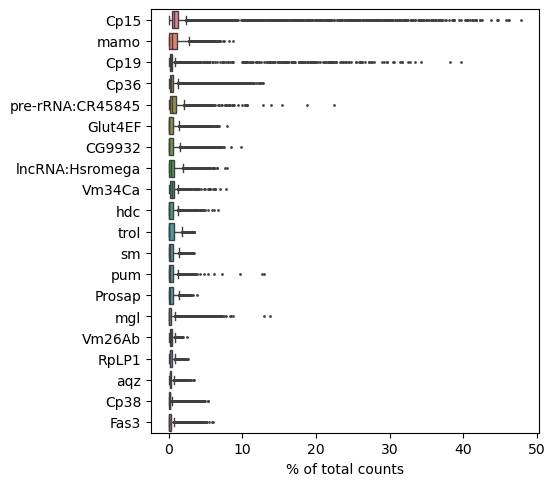

In [29]:
# look at the highest expressed genes
sc.pl.highest_expr_genes(adata, n_top=20)

In [30]:
#filter out cells with low gene count and genes that are detected in 3 or less cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [31]:
# annotate the group of mitochondrial genes as "mt" 
adata.var["mt"] = adata.var_names.str.startswith("mt:")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)


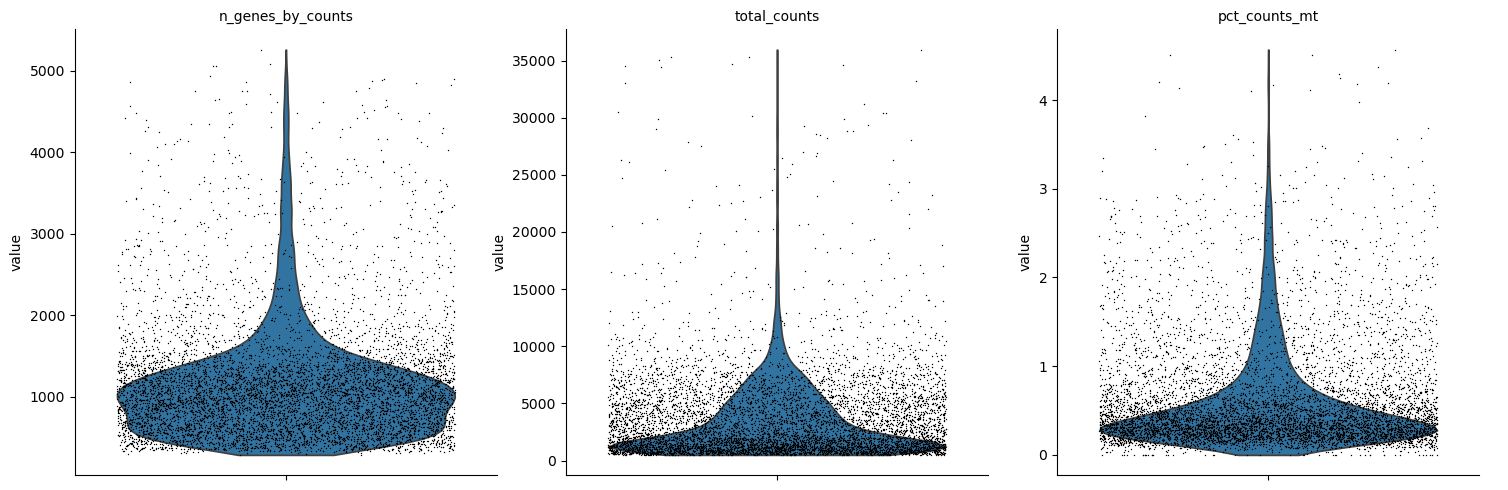

In [32]:
# Violin plot to look at the number of genes and cells
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# comment

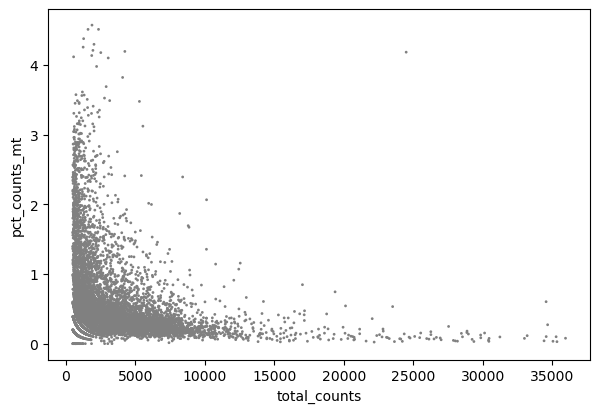

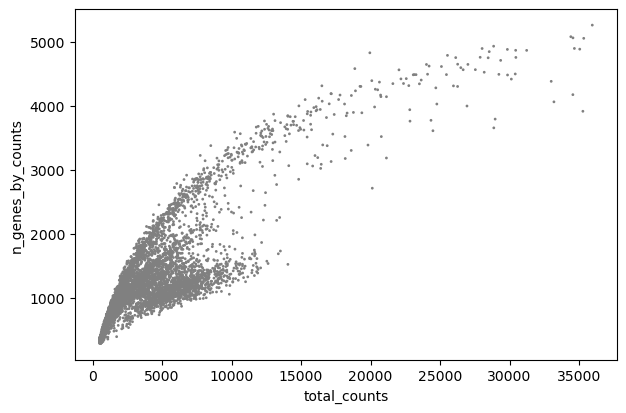

In [33]:
#scatter plots
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

We see that the numbers of mitochondrial genes for each count are below 5 which is quite low, indicating that the cells detected should be healthy. 
We also see that most cells contain a few thousand genes, and there are only some cells that pass over 30'000 genes.
For now we keep the filtering to a minimum and might come back to it

In [34]:
#adata = adata[adata.obs.n_genes_by_counts < 5000, :]
#adata = adata[adata.obs.pct_counts_mt < 5, :].copy() 

##### Normalization 
In order to be able to compare the gene counts we normalize the data and regress out the effect of the counts per cell and percentage of mitochondrial genes expressed.

In [35]:
#normalize the total count so that the counts become comparable among cells
sc.pp.normalize_total(adata, target_sum=1e4)
# take the log of the data
sc.pp.log1p(adata)

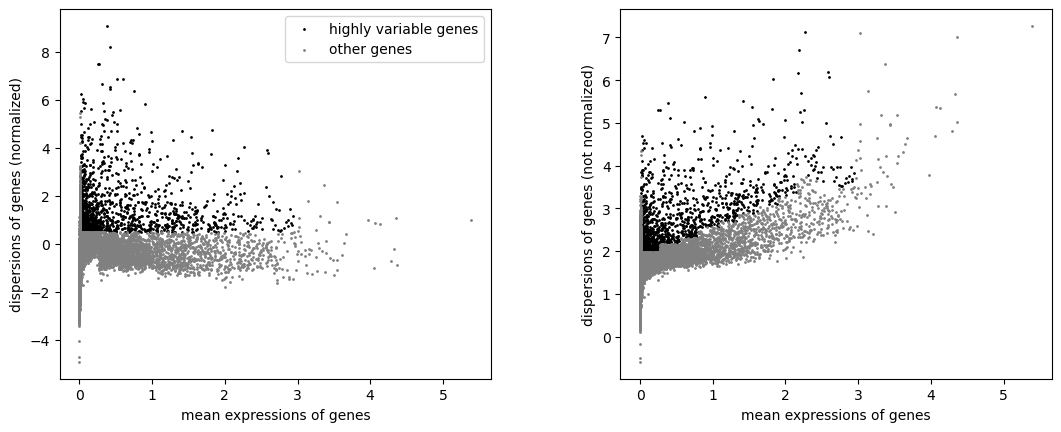

In [36]:
#look at the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# comment

In [37]:
#Set the normalized and logarithmized gene expr for later use to .raw
adata.raw = adata.copy()

#filter 
adata = adata[:, adata.var.highly_variable]
#regress out effects of total count per cell
sc.pp.regress_out(adata, ["total_counts"])
#scale the values
sc.pp.scale(adata, max_value=10)

c:\Users\Gianna Biino\anaconda3\envs\scbio\Lib\site-packages\scanpy\preprocessing\_simple.py:709: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


##### Principal Component Analysis
We run a PCA on the data in order to analyse the variation in the data

In [38]:
#compute the PCA
sc.tl.pca(adata, svd_solver="arpack")

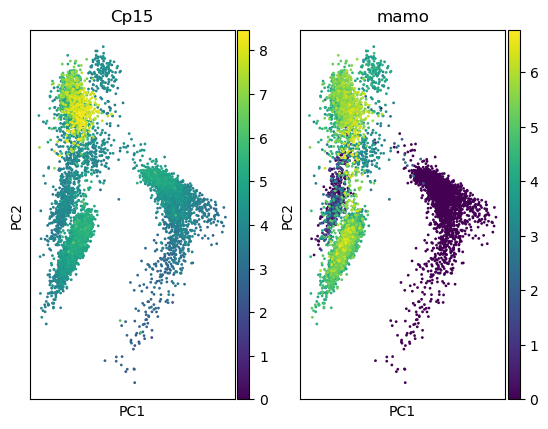

In [39]:
# plot the PCA for the gene Cp15 and mamo
fig, axes = plt.subplots(1,2)
sc.pl.pca(adata, color="Cp15", ax=axes[0], show=False)
sc.pl.pca(adata, color="mamo", ax=axes[1], show=False)
plt.show()


We see that there is not a big difference of the expression of Cp15 between cells. Mamo however is highly expressed in some cells while not expressed in others.
These two plots only consider the first two principal components though. We have to inspect the contributions of each PC in order to consider as much of the variance as possible.

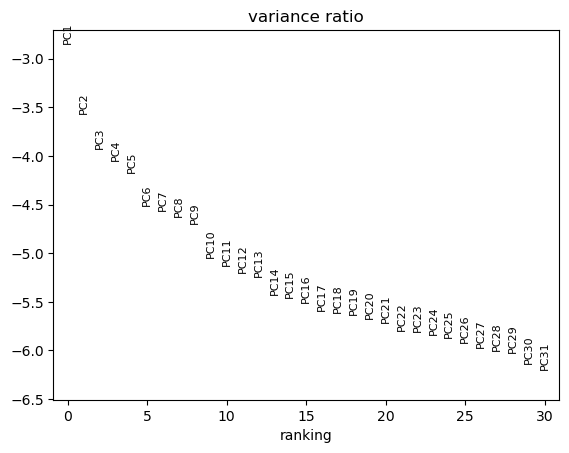

In [40]:
sc.pl.pca_variance_ratio(adata, log=True)

In [41]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [42]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    #random_state=0,
    #flavor="igraph",
    #n_iterations=2,
    #directed=False,
)

C:\Users\Gianna Biino\AppData\Local\Temp\ipykernel_2876\1252988234.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


In [43]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [44]:
sc.tl.umap(adata)

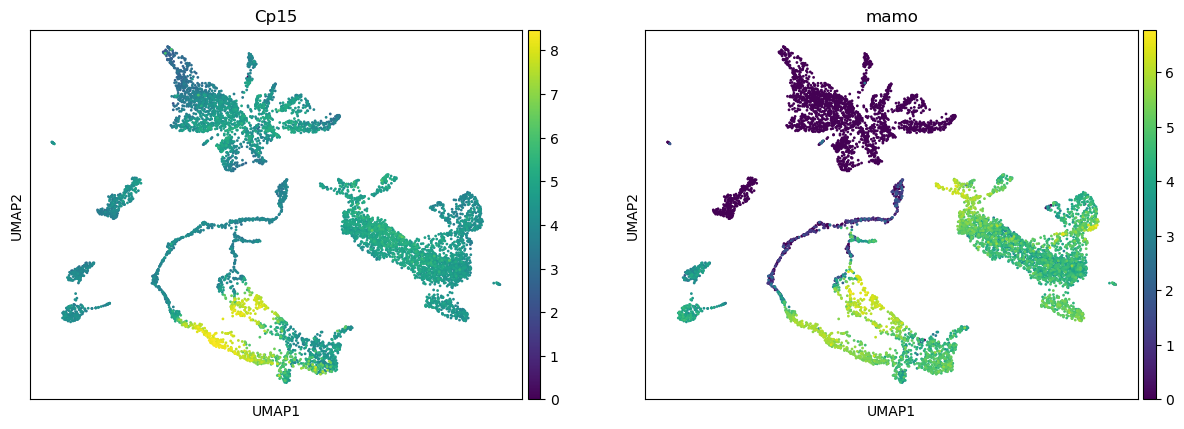

In [45]:
sc.pl.umap(adata, color=["Cp15", "mamo"])

c:\Users\Gianna Biino\anaconda3\envs\scbio\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\Gianna Biino\anaconda3\envs\scbio\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\Gianna Biino\anaconda3\envs\scbio\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:440: PerformanceWarni

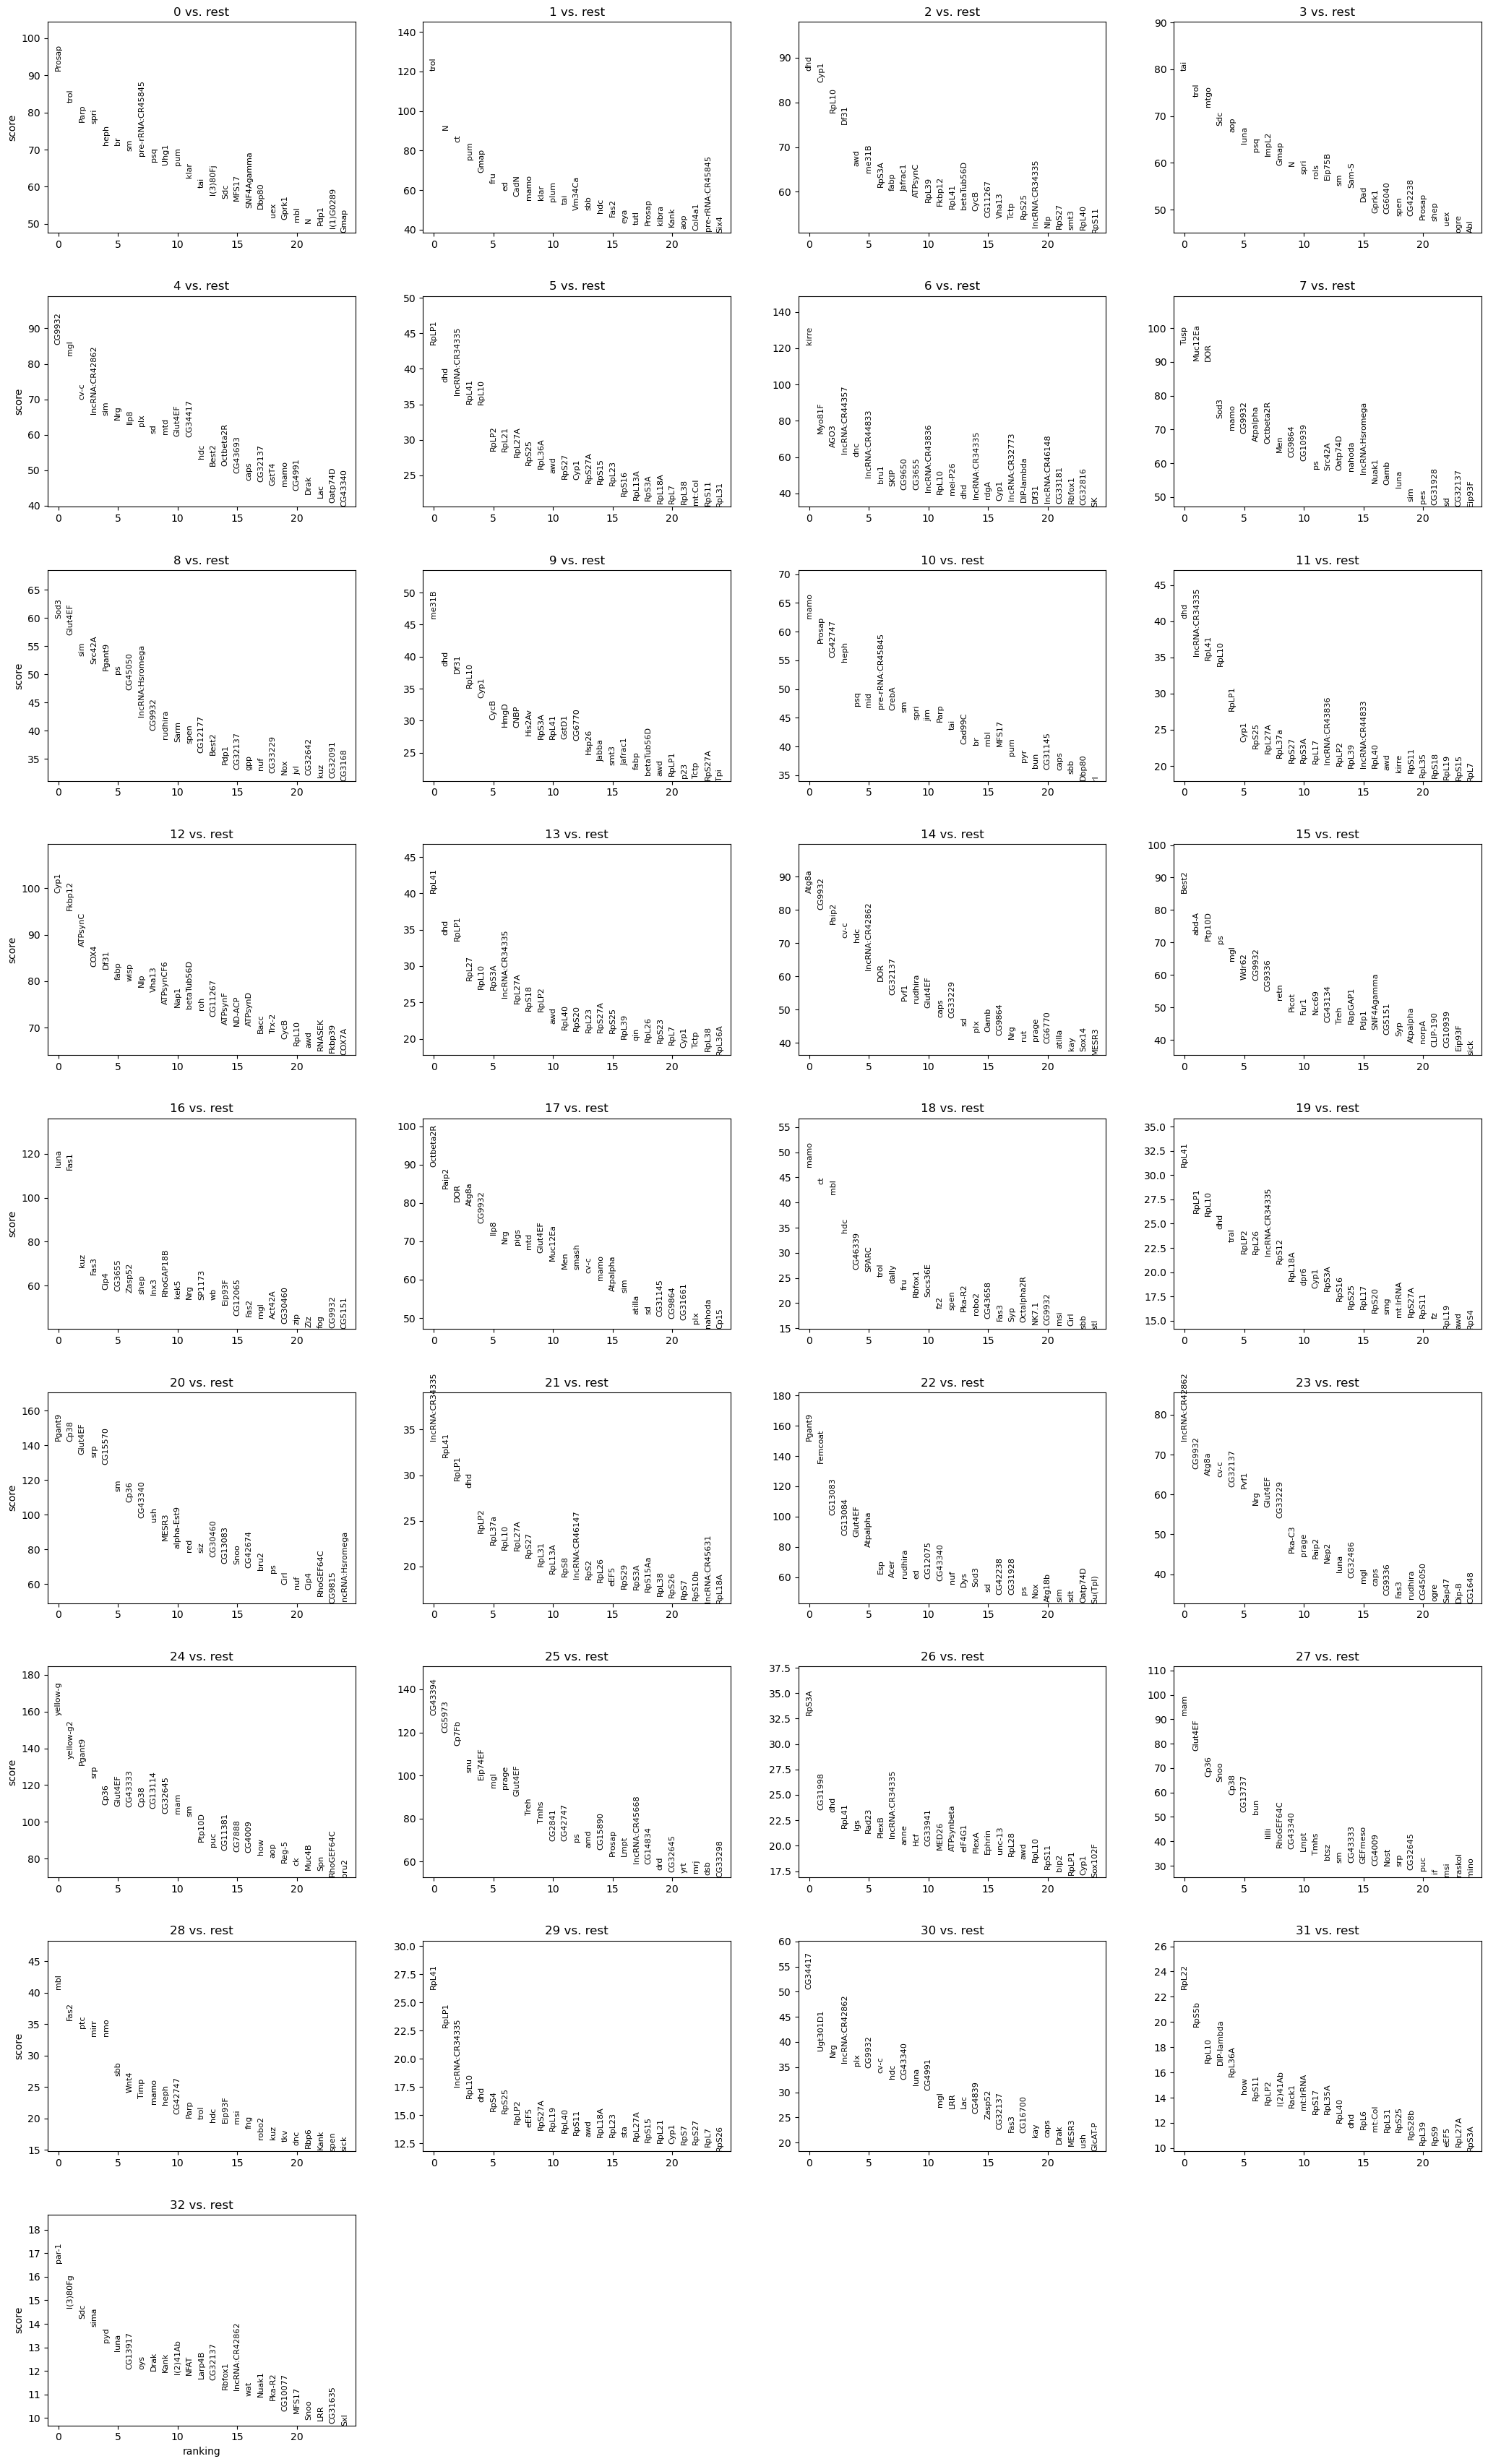

In [46]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished (0:00:24)


c:\Users\Gianna Biino\anaconda3\envs\scbio\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\Gianna Biino\anaconda3\envs\scbio\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\Gianna Biino\anaconda3\envs\scbio\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:440: PerformanceWarni

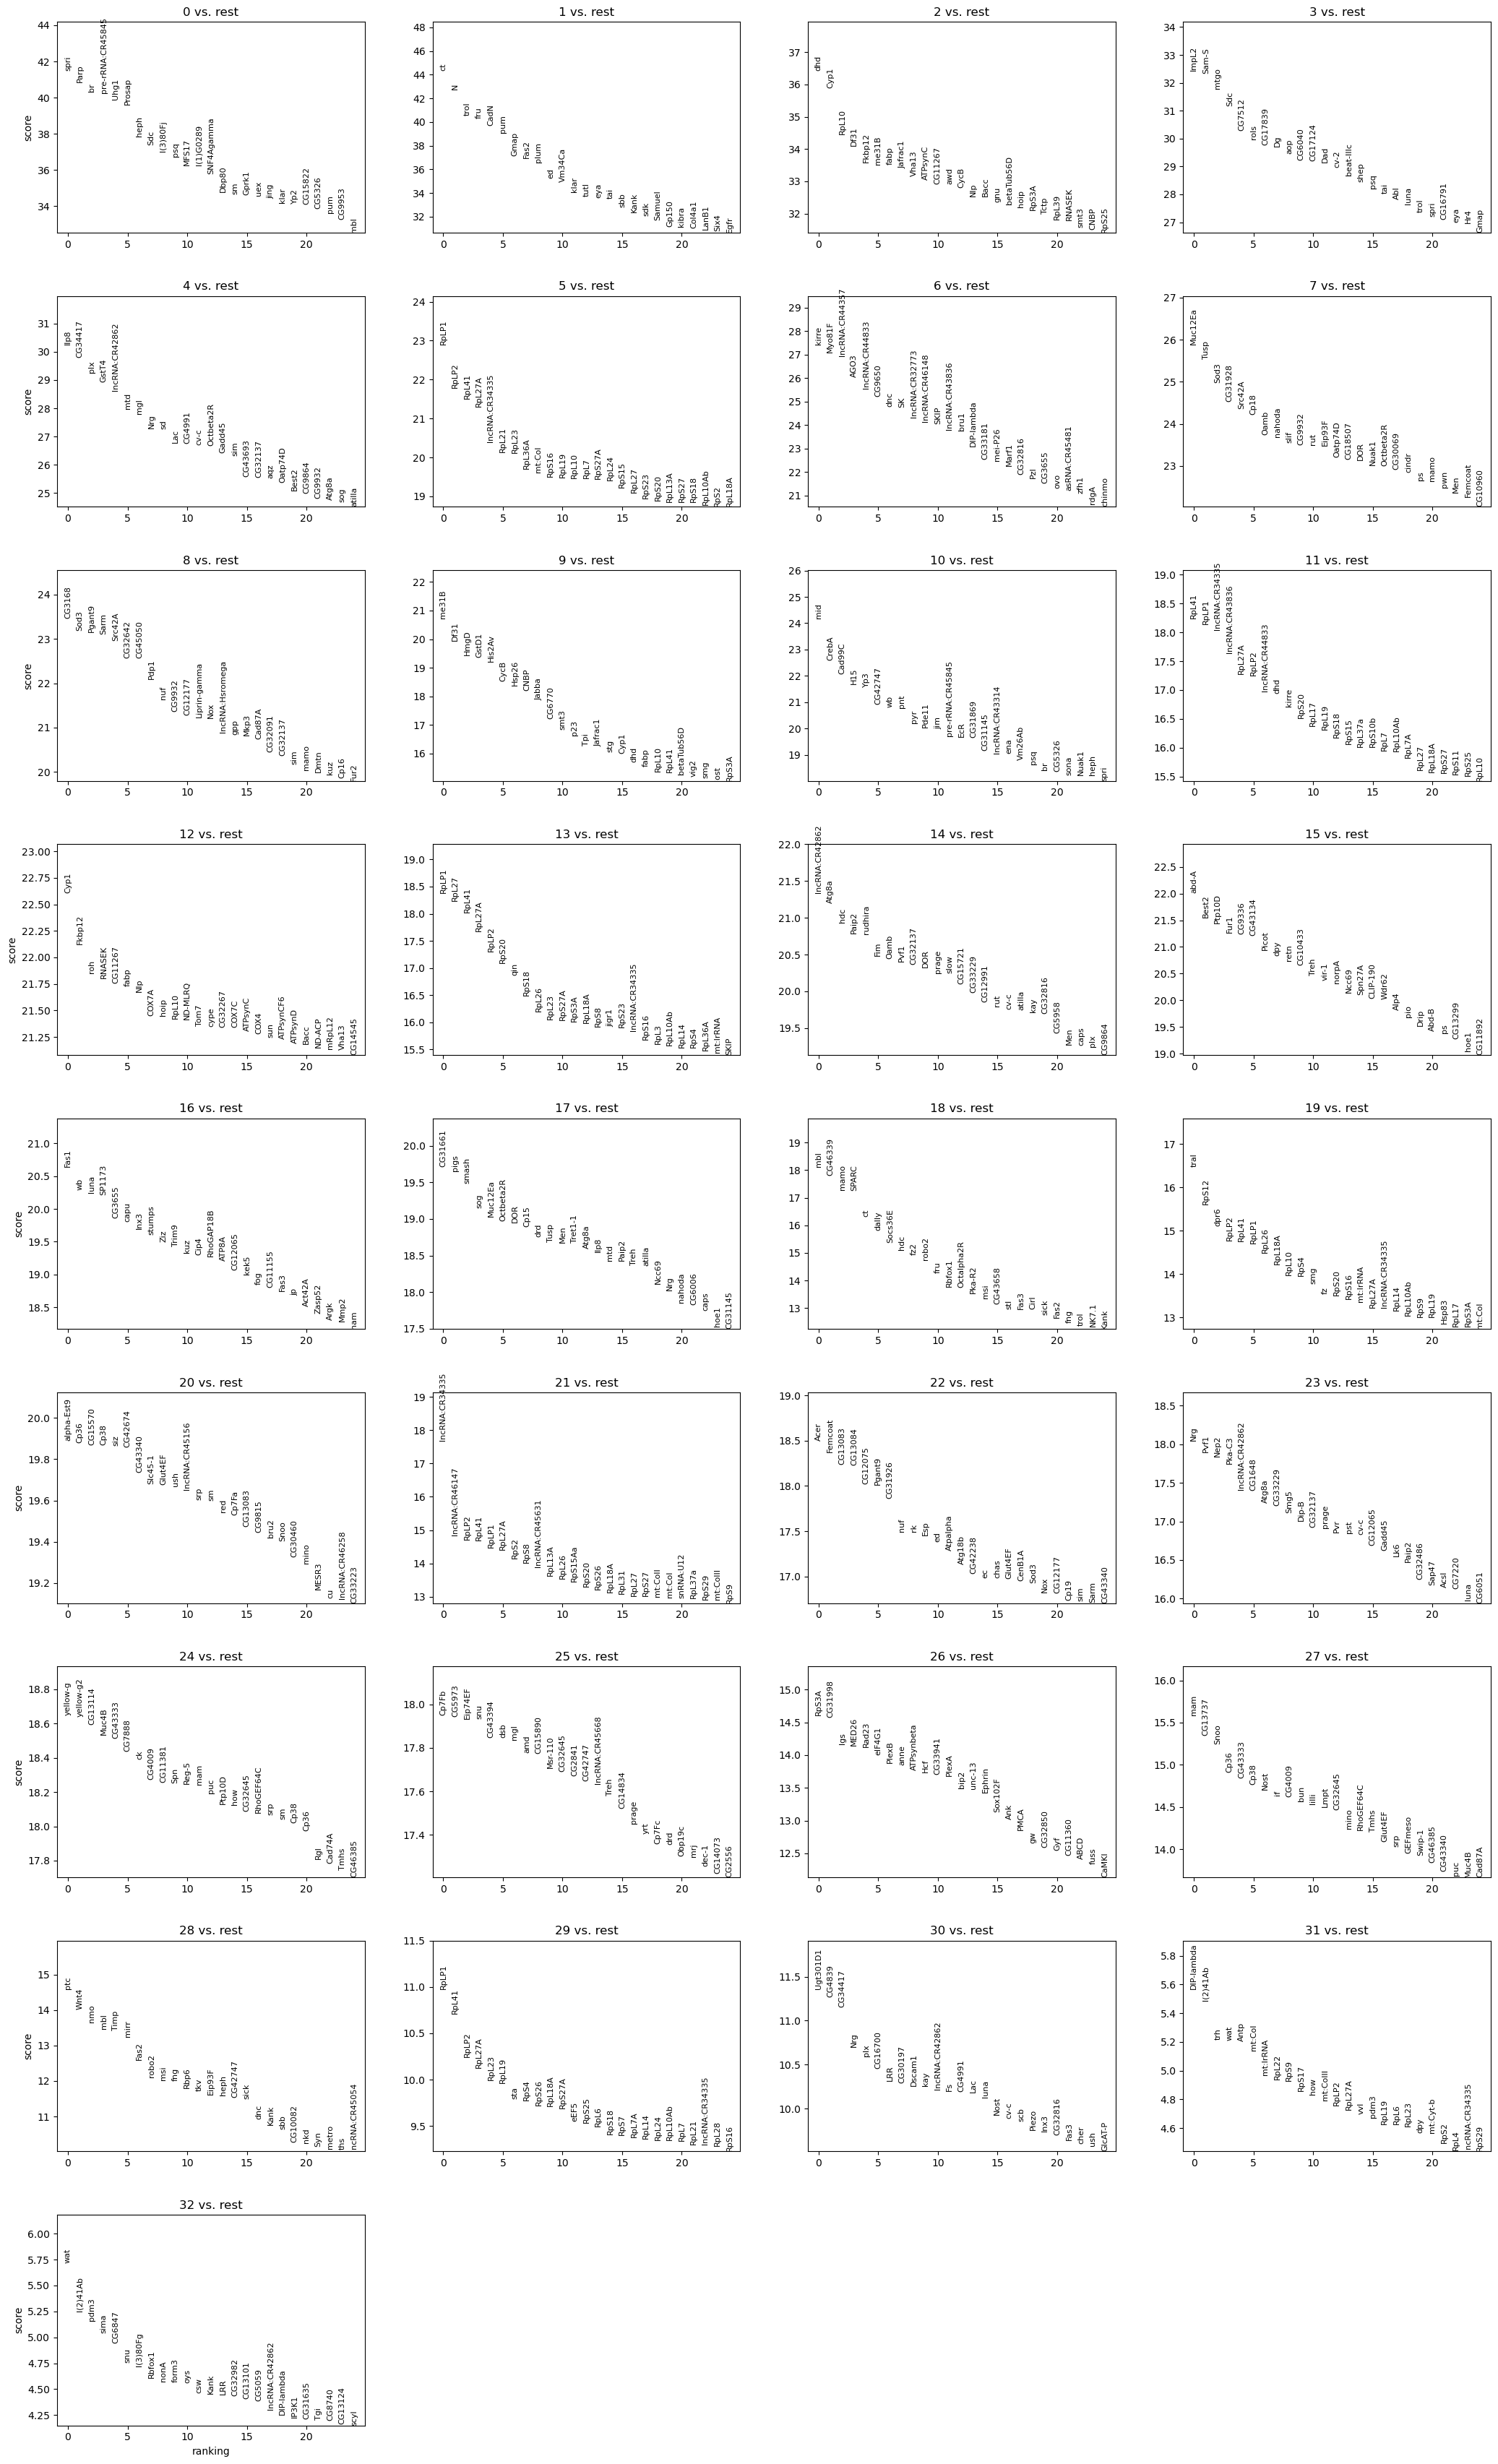

In [47]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished (0:00:14)


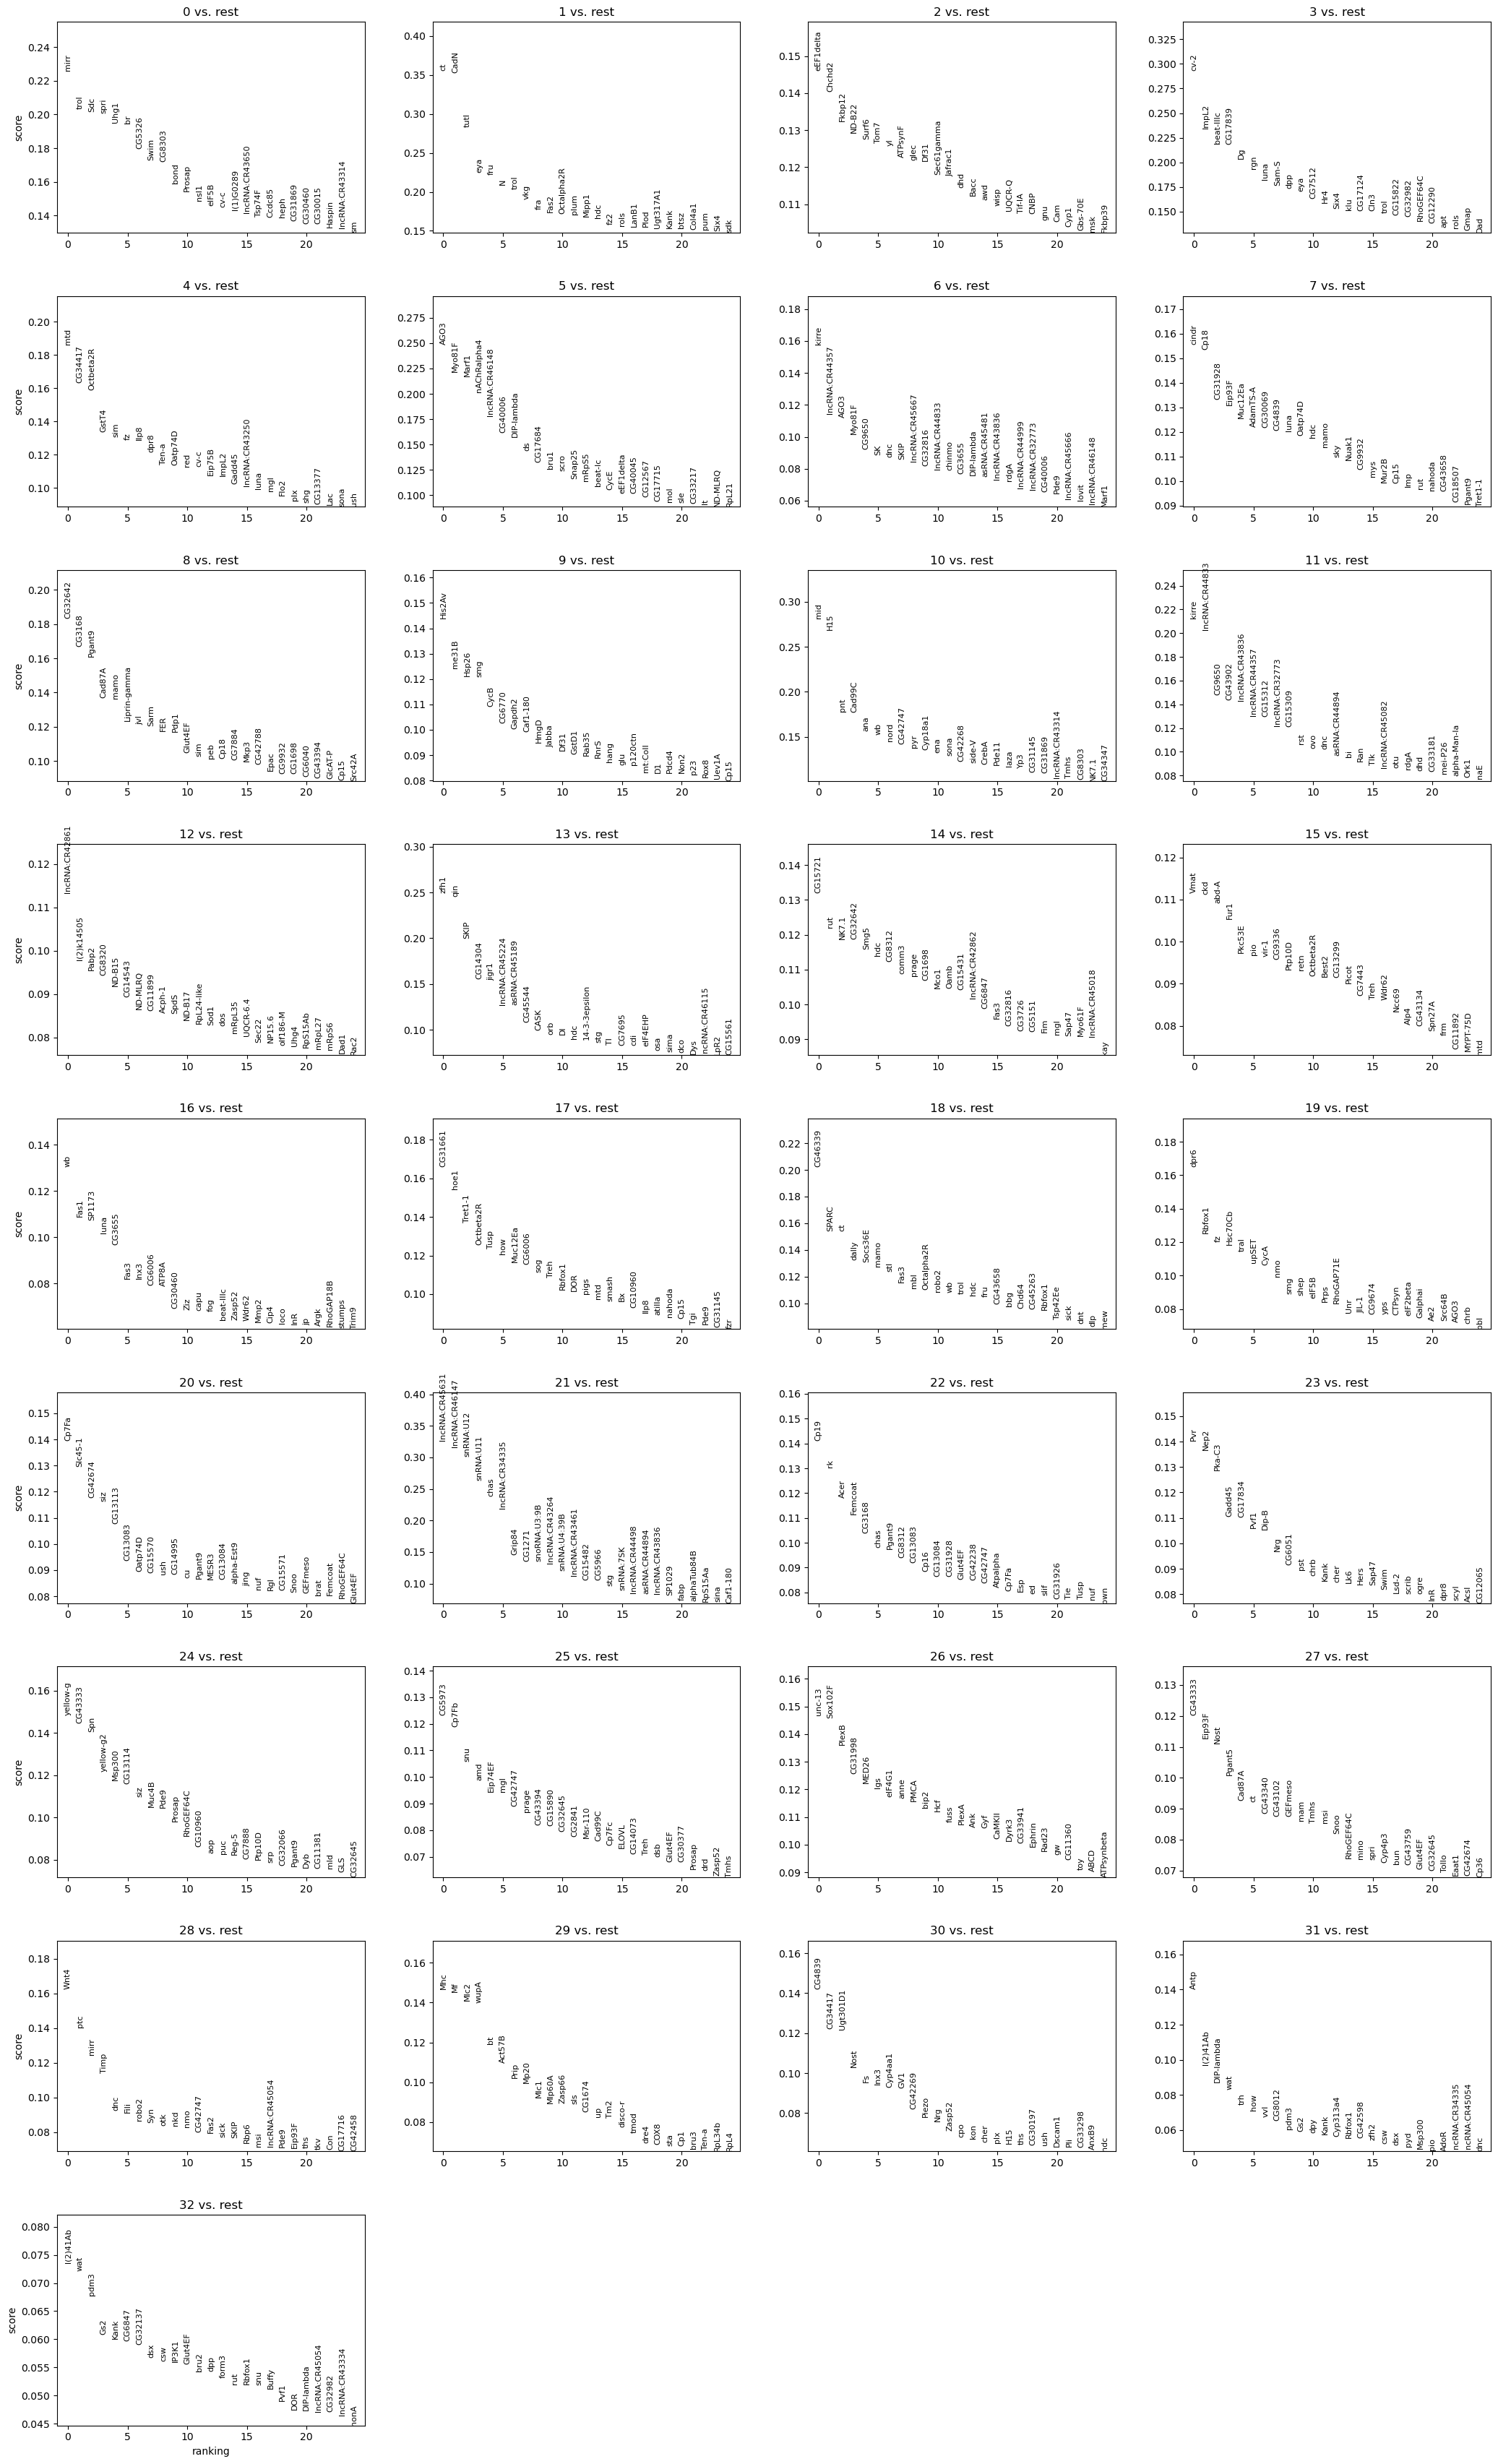

In [48]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [49]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

0     1          2          3          4               5  \
0  mirr    ct  eEF1delta       cv-2        mtd            AGO3   
1  trol  CadN     Chchd2      ImpL2    CG34417          Myo81F   
2   Sdc  tutl     Fkbp12  beat-IIIc  Octbeta2R           Marf1   
3  spri   eya     ND-B22    CG17839      GstT4     nAChRalpha4   
4  Uhg1   fru      Surf6         Dg        sim  lncRNA:CR46148   

                6        7        8       9  ...       23         24       25  \
0           kirre    cindr  CG32642  His2Av  ...      Pvr   yellow-g   CG5973   
1  lncRNA:CR44357     Cp18   CG3168   me31B  ...     Nep2    CG43333    Cp7Fb   
2            AGO3  CG31928   Pgant9   Hsp26  ...   Pka-C3        Spn      snu   
3          Myo81F   Eip93F   Cad87A     smg  ...   Gadd45  yellow-g2      amd   
4          CG9650  Muc12Ea     mamo    CycB  ...  CG17834     Msp300  Eip74EF   

        26       27    28    29        30          31        32  
0   unc-13  CG43333  Wnt4   Mhc    CG4839        Antp  l(2)41Ab  
1  Sox102F   Eip93F   ptc    Mf   CG34417    l(2)41Ab       wat  
2    PlexB     Nost  mirr  Mlc2  Ugt301D1  DIP-lambda      pdm3  
3  CG31998   Pgant5  Timp  wupA      Nost         wat       Gs2  
4    MED26   Cad87A   dnc    bt        Fs         trh      Kank  

[5 rows x 33 columns]

In [50]:
'''result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)'''

'result = adata.uns["rank_genes_groups"]\ngroups = result["names"].dtype.names\npd.DataFrame(\n    {\n        f"{group}_{key[:1]}": result[key][group]\n        for group in groups\n        for key in ["names", "pvals"]\n    }\n).head(5)'

ranking genes
    finished (0:00:03)


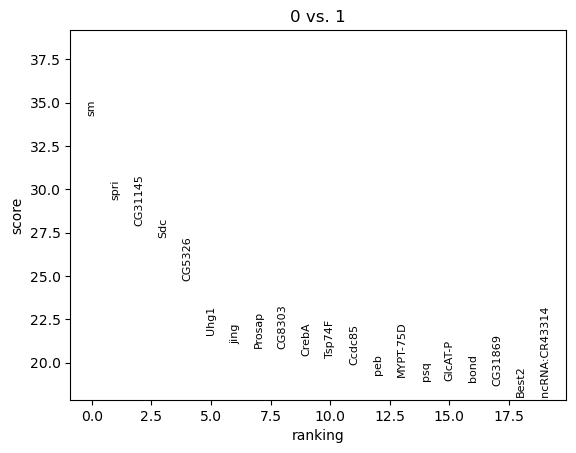

In [51]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

c:\Users\Gianna Biino\anaconda3\envs\scbio\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1331: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


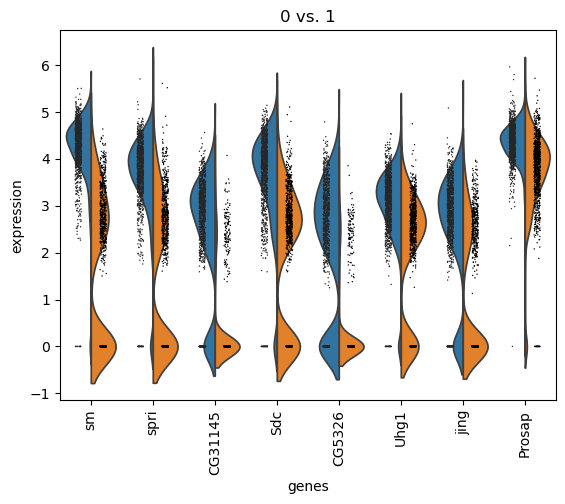

In [52]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)


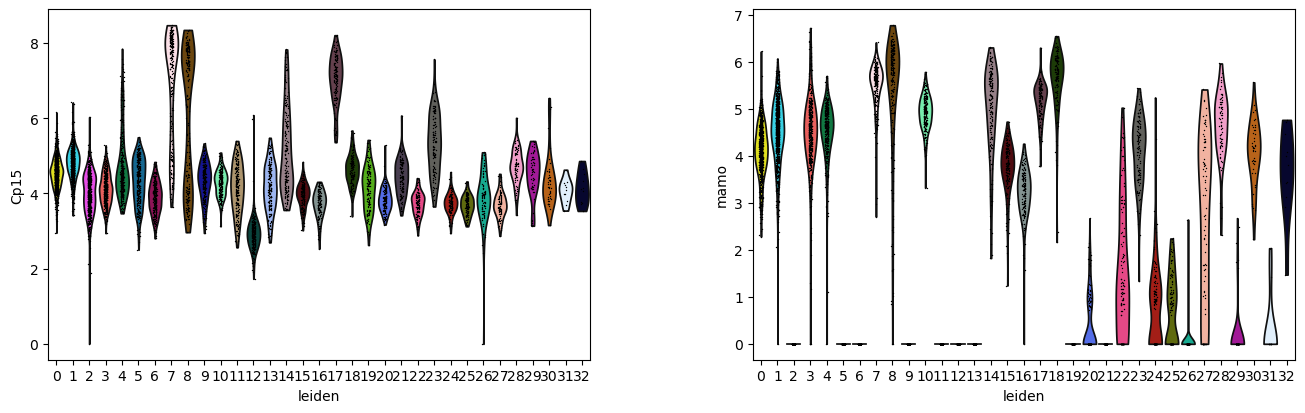

In [53]:
sc.pl.violin(adata, ["Cp15", "mamo"], groupby="leiden")